In [1]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer import MCMC, NUTS
import torch
import numpy as np
import matplotlib.pyplot as plt
print(torch.cuda.is_available())
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#torch.set_default_tensor_type('torch.cuda.FloatTensor')

class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, prior_scale=10.):
        super().__init__()
        
        #self.fc1.weight = PyroSample(dist.Normal(torch.tensor(0., device="cuda"), 1.).expand([h1, 1]).to_event(2))
        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

False
cpu


TABS_DEM/table_2022_03_05.csv 0
825
TABS_DEM/table_2022_06_23.csv 1
875
TABS_DEM/table_2022_05_08.csv 2
825
TABS_DEM/table (1).csv 3
525
TABS_DEM/table_2022_07_11.csv 4
675
TABS_DEM/talbe_2022_06_24.csv 5
875
TABS_DEM/table.csv 6
504
TABS_DEM/tablee.csv 7
999
TABS_DEM/table (2).csv 8
551
TABS_DEM/table_2022_06_22.csv 9
651
(7305, 2)
(7305, 2)
x: (7305, 2, 1) y: (7305, 2) number of points 7305
xtrain: (3652, 2, 1) ytrian: (3652, 2)
xtest: (3653, 2, 1) ytest: (3653, 2)


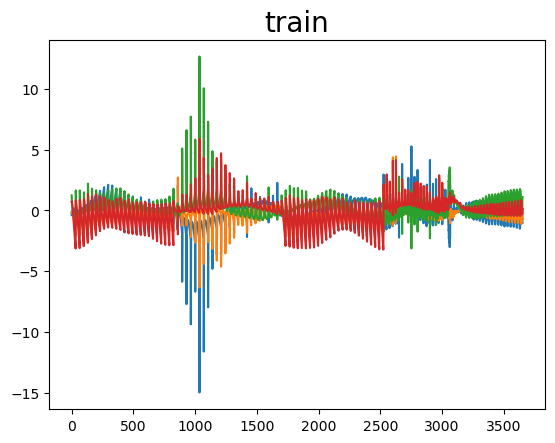

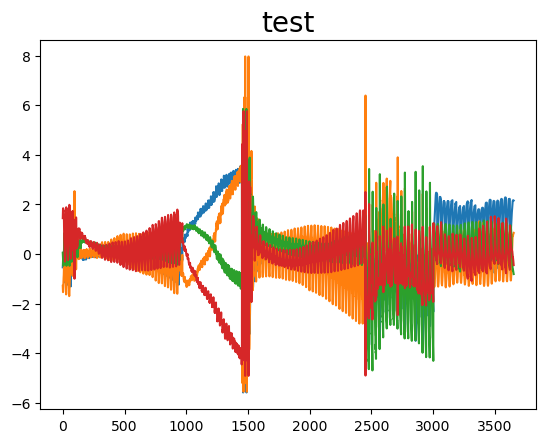

In [2]:
from pathlib import Path, PurePosixPath
import os
from numpy import array
from numpy import hstack


def create_data(n,df):
 x1  = array(df['cc4'].values).reshape(n,1)
 x2  = array(df['cc3'].values).reshape(n,1)
 x3  = array(df['gap'].values).reshape(n,1)
 y1  = array(df['cc1'].values).reshape(n,1)
 y2  = array(df['cc2'].values).reshape(n,1)
 y3  = array(df['phase'].values).reshape(n,1)
 X = hstack((x1, x2))
 Y = hstack((y1, y2))
 return X, Y


#path = r'TABS_UNDU_04/'
path = r'TABS_DEM/'
files = Path(path).glob('*.csv')
files1 = Path(path).glob('*.csv')
list_of_files = list(files1)
sample_rate = 100
stoper = 25000
starter = 5000


dfs = list()
for i, f in enumerate(files):
    print(f,i)
    df = pd.read_csv(f)
    print(len(df))
    dfs.append(df)


merged = pd.concat(dfs, ignore_index=True )
merged.reset_index()
merged = merged.iloc[:]
###########################################
merged_n=(merged-merged.mean())/merged.std()

x , y = create_data(len(merged_n),merged_n)


print(x.shape)
print(y.shape)
#points = len(y)
x = x.reshape(x.shape[0], x.shape[1], 1)
print("x:", x.shape, "y:", y.shape, "number of points" , len(y))

points = len(x)
spliter = int(points * 0.5)

xtrain = x[:spliter,:,:]
ytrain = y[:spliter,:]

xtest = x[spliter:,:,:]
ytest = y[spliter:,:]
plt.figure()
plt.title("train",fontsize= 20)

#x_ax = range(len(xtrain))

plt.plot(ytrain[:,0],label = "ytrain")
plt.plot(xtrain[:,0],label = "xtrain")
plt.plot(ytrain[:,1],label = "ytrain")
plt.plot(xtrain[:,1],label = "xtrain")
print("xtrain:", xtrain.shape, "ytrian:", ytrain.shape)


plt.figure()
plt.title("test",fontsize= 20)
plt.plot(xtest[:,0],label = "xtest")
plt.plot(ytest[:,0],label = "ytest")
plt.plot(xtest[:,1],label = "xtest")
plt.plot(ytest[:,1],label = "ytest")
print("xtest:", xtest.shape, "ytest:", ytest.shape)

In [7]:
model = BNN()
#model.to(device)
# Set Pyro random seed
pyro.set_rng_seed(44543520)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=True)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=100)

xtrain1 = xtrain[:,:,0] 
xtest1 = xtest[:,:,0] 
print('size x',xtrain.size,'  size y', ytrain.size)
print('shape x',xtrain1.shape,'  shape y', ytrain.shape)
# Convert data to PyTorch tensors
x_train = torch.from_numpy(xtrain1[:,0]).float()
#x_train = x_train.cuda() 
y_train = torch.from_numpy(ytrain[:,0]).float()
#y_train = y_train.cuda()
#print('size x',x_train.size,'  size y', y_train.size)
# Run MCMC
mcmc.run(x_train, y_train)

size x 7304   size y 7304
shape x (3652, 2)   shape y (3652, 2)


Warmup:   0%|                                                                                                          | 0/200 [00:00, ?it/s]/home/jbiernat/anaconda3/envs/AT/lib/python3.10/site-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████████████████████████████████████| 200/200 [04:49,  1.45s/it, step size=1.07e-03, acc. prob=0.949]                     


In [8]:
from pyro.infer import Predictive
xlims = [0, 500]
ylims = [-1.5, 2.5]
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
#x_test = torch.linspace(xlims[0], xlims[1], 3000)
x_test = torch.from_numpy(xtest1).float()
preds = predictive(x_test)
print(preds['obs'].shape)


torch.Size([100, 7306])


In [9]:
def plot_predictions(preds):
    x_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    x_std = preds['obs'].T.detach().numpy().std(axis=1)
    print(x_pred.shape)
    print(x_test.shape)
    fig, ax = plt.subplots(figsize=(10, 7))
    xlims = [0, 2000]
    ylims = [-20.5, 20.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("time stamp", fontsize=30)
    plt.ylabel("corrector", fontsize=30)
    n = 1460
    time_x = np.arange(0, len(x_pred[n:]))
    ax.plot( x_pred[n:], '-', linewidth=1, alpha=1.,color="#408765", label="predictive mean")
    ax.plot( x_test[:,0], 'o',markersize=2 , color="black", label="test measurment")
    #ax.fill_between(x_pred,x_pred - 2 * x_std, x_pred + 2 * x_std, alpha=0.96, color='#86cfac', zorder=5)
    #ax.plot( x_pred + 2 * x_std, '-',markersize=0.01, alpha=0.3 , color="black", label="upper")
    #ax.plot( x_pred - 2 * x_std, '-',markersize=0.01 ,alpha=0.3, color="black", label="lower")
    ax.fill_between(x=time_x, y1=x_pred[n:] + 2 * x_std[n:], y2=x_pred[n:] - 2 * x_std[n:], color='red',  interpolate=False, alpha=.45)
    plt.legend(loc=4, fontsize=15, frameon=False)
    plt.savefig('BNN_err.png')
    plt.show()

(7306,)
torch.Size([3653, 2])


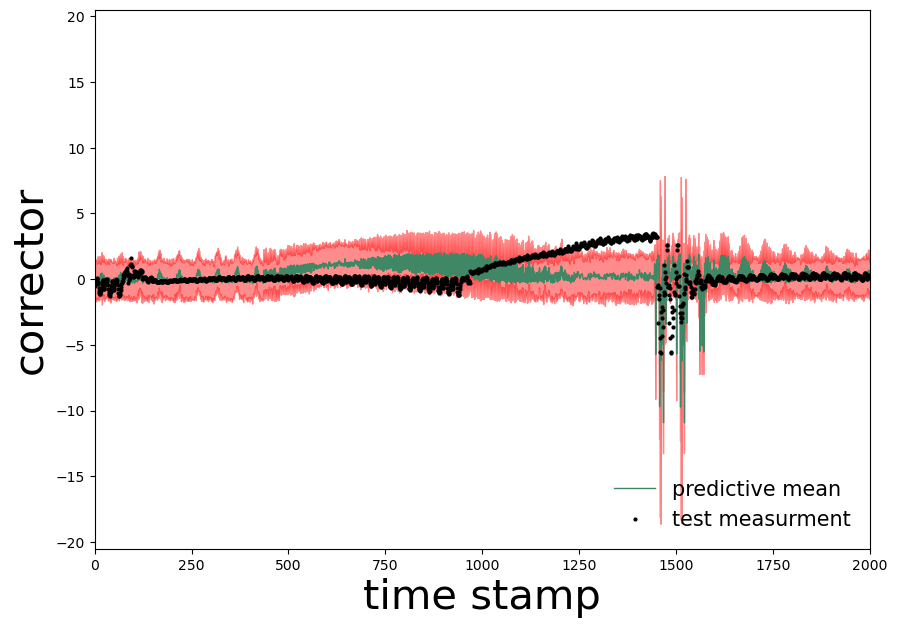

In [10]:
plot_predictions(preds)

In [7]:
x_pred = preds['obs'].T.detach().numpy().mean(axis=1)
x_std = preds['obs'].T.detach().numpy().std(axis=1)
np.set_printoptions(precision=2)
for i in range(len(x_pred)):
    print('mean  ',x_pred[i],'        std  ', x_std[i],'  +2 sigma   ',x_pred[i] + 2* x_std[i],'  -2 sigma   ',x_pred[i] - 2* x_std[i])

mean   -0.07090978         std   0.64147824   +2 sigma    1.2120466977357864   -2 sigma    -1.3538662642240524
mean   -0.1032177         std   0.6871285   +2 sigma    1.2710392698645592   -2 sigma    -1.4774746671319008
mean   -0.39251578         std   0.6691821   +2 sigma    0.9458484649658203   -2 sigma    -1.7308800220489502
mean   -0.1599872         std   0.75692326   +2 sigma    1.353859320282936   -2 sigma    -1.6738337129354477
mean   -0.18456014         std   0.6301434   +2 sigma    1.0757266730070114   -2 sigma    -1.4448469430208206
mean   -0.03066143         std   0.8040638   +2 sigma    1.5774661637842655   -2 sigma    -1.6387890242040157
mean   -0.17724532         std   0.70768356   +2 sigma    1.2381218075752258   -2 sigma    -1.5926124453544617
mean   -0.19189985         std   0.67582643   +2 sigma    1.1597530096769333   -2 sigma    -1.5435527116060257
mean   -0.24892227         std   0.64063764   +2 sigma    1.0323529988527298   -2 sigma    -1.5301975458860397
mean   -